
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)


# Часть 1


---



Требования

1. Используйте фреймворк [Pytorch](https://pytorch.org/)

2. Не используйте предобученные модели.

3. Можете загрузить готовую модель или использовать собственную архитектуру.

4. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

5. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

6. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

## Подготовка данных

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # means and standard deviations for each color channel (of our dataset!) (RGB) in the image. From Cifar10 analisis article
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # crop, flip and add padings to create more data from our datasen and create something like dropout on data level
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
#donloading data
train_dataset = torchvision.datasets.CIFAR10(root='./dataset1/',
                                             train=True,
                                             transform=train_tfms,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./dataset1/',
                                            train=False,
                                            transform=valid_tfms)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
# Creating data loaders
batch_size = 400
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_dataset, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#moving data to gpu (or cpu), standart move .to(device) works slower and often throws errors in my case
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#check device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# moving datasets
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Модель

In [ ]:
def accuracy(outputs, labels): # create accuracy metric
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):   # base (img) classification block
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False): #convolutional block
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase): # actual ResNet model classification + conv blocks
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device) # 3 - RGB, 10 - classes
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Тренировка и тестирование модели

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,       #trainer
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in tqdm(range(epochs)):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [] # training statistic saves here
# training parametrs
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, #train model
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00151, train_loss: 0.1257, val_loss: 0.3196, val_acc: 0.8998
Epoch [1], last_lr: 0.00435, train_loss: 0.2212, val_loss: 0.4848, val_acc: 0.8388
Epoch [2], last_lr: 0.00759, train_loss: 0.3699, val_loss: 0.6219, val_acc: 0.8095
Epoch [3], last_lr: 0.00971, train_loss: 0.4212, val_loss: 0.6819, val_acc: 0.7832
Epoch [4], last_lr: 0.00994, train_loss: 0.4019, val_loss: 0.6872, val_acc: 0.7741
Epoch [5], last_lr: 0.00950, train_loss: 0.3977, val_loss: 0.5227, val_acc: 0.8265
Epoch [6], last_lr: 0.00867, train_loss: 0.3725, val_loss: 0.6943, val_acc: 0.7725
Epoch [7], last_lr: 0.00750, train_loss: 0.3417, val_loss: 0.4171, val_acc: 0.8655
Epoch [8], last_lr: 0.00611, train_loss: 0.3231, val_loss: 0.4320, val_acc: 0.8563
Epoch [9], last_lr: 0.00463, train_loss: 0.2785, val_loss: 0.3483, val_acc: 0.8820
Epoch [10], last_lr: 0.00317, train_loss: 0.2349, val_loss: 0.3072, val_acc: 0.8975
Epoch [11], last_lr: 0.00188, train_loss: 0.1887, val_loss: 0.2997, val_acc: 0.9004
Ep

## Метрики модели

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

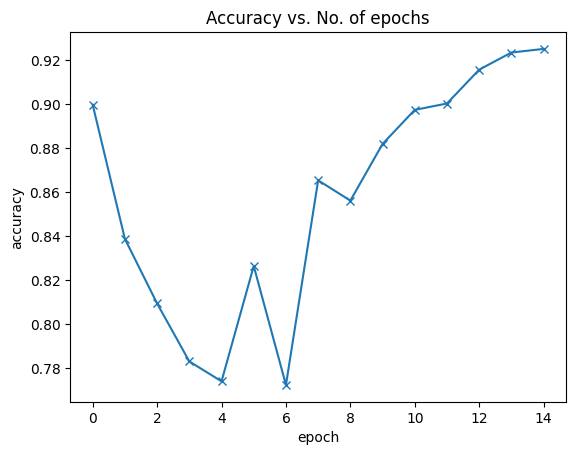

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

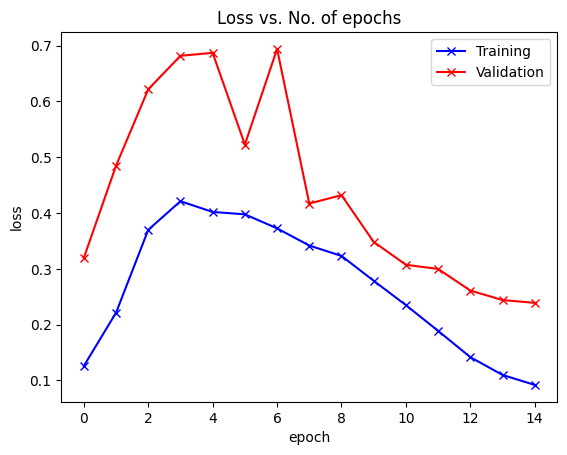

In [ ]:
plot_losses(history)

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet.pth')

In [ ]:
model = torch.load('./cifar10-resnet.pth')

# Часть 2


---



1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


## Подготовка данных



In [ ]:
!pip install datasets transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.4 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import ViTFeatureExtractor
from datasets import load_metric
from transformers import TrainingArguments
from transformers import ViTForImageClassification
import sys
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import Trainer

In [ ]:
#set up rinning devise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# donloading datasets
dataset_train = load_dataset(
    'cifar10',
    split='train',
    ignore_verifications=False
)

dataset_train

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [ ]:
dataset_test = load_dataset(
    'cifar10',
    split='test',
    ignore_verifications=False
)

dataset_test

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [ ]:
#check labels
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

## Модель

In [ ]:
# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
#create transform for data
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor( #vit feature extractor
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

In [ ]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# transform the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

In [ ]:
def collate_fn(batch): # create dictionary { pixels, label }
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [ ]:
metric = load_metric("accuracy", trust_remote_code=True) # create validation metric
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-10-5401ba2f51cd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [ ]:
training_args = TrainingArguments( #set up training parametrs
  output_dir="./cifar",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained( #load model
    model_id,
    num_labels=len(labels)
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device) # move model to gpu

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Тренировка модели (Fine-tuning)

In [ ]:
trainer = Trainer( # use training parametrs
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()  # 1 epoch train
# save tokenizer with the model
trainer.save_model()
# statistic for model not necessary, but we can use it still
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.429100,0.411839,0.906100
200,0.244000,0.353533,0.905100
300,0.333500,0.362723,0.897800
400,0.266200,0.320930,0.908300
500,0.306400,0.343036,0.901200
600,0.268100,0.330649,0.904200
700,0.229200,0.255756,0.929500
800,0.203600,0.231503,0.932700
900,0.188000,0.180255,0.946700
1000,0.181400,0.212723,0.939400


Step,Training Loss,Validation Loss,Accuracy
100,0.429100,0.411839,0.906100
200,0.244000,0.353533,0.905100
300,0.333500,0.362723,0.897800
400,0.266200,0.320930,0.908300
500,0.306400,0.343036,0.901200
600,0.268100,0.330649,0.904200
700,0.229200,0.255756,0.929500
800,0.203600,0.231503,0.932700
900,0.188000,0.180255,0.946700
1000,0.181400,0.212723,0.939400


***** train metrics *****
  epoch                    =          1.0
  total_flos               = 3608760698GF
  train_loss               =       0.2047
  train_runtime            =   1:45:09.35
  train_samples_per_second =        7.925
  train_steps_per_second   =        0.495


model import / export

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount my google drive (model exports in folder so we can't just download one file)

Mounted at /content/gdrive


In [ ]:
!cp -r ./cifar /content/gdrive/'My Drive'/'Colab Notebooks'/techSchool/task1/model2 # copy to google d

In [ ]:
!cp -r /content/gdrive/'My Drive'/'Colab Notebooks'/techSchool/task1/model2/cifar ./cifar # copy from google d

## Тестирование модели

In [ ]:
# import our fine-tuned model
model_name_or_path = './cifar/model2/cifar'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
%%time
# test

correct = 0
datasetForTest = dataset_test

total = 1000
i = 0

with torch.no_grad():
    for data in datasetForTest:
        i +=1
        images, labels = data.values()
        inputs = feature_extractor_finetuned(images, return_tensors="pt") #img to tensor

        logits = model_finetuned(**inputs).logits #prediction
        outputs = predicted_label = logits.argmax(-1).item() #choose higher prediction

        if outputs == labels:
          correct += 1

        sys.stdout.write("\rProgress: %d / %d" % (i, total)) #loading scale
        sys.stdout.flush()

        if i==total: break
print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')

Progress: 1000 / 1000
Accuracy of the network on the 10000 test images: 97 %
CPU times: user 7min 40s, sys: 1.53 s, total: 7min 42s
Wall time: 7min 52s


## Метрики модели

In [10]:
# model metrics from training step
history_acc = [0.906100,0.905100,0.897800,0.908300,0.901200,0.904200,0.929500,0.932700,0.946700,0.939400,0.937300,0.918500,0.937200,0.947000,0.954400,0.956100,0.960600,0.955600,0.963200,0.958400,0.965200,0.968500,0.969800,0.967100,0.973300,0.972500,0.975300,0.975500,0.978700,0.979000,0.979500]
history_t_loss = [0.429100,0.244000,0.333500,0.266200,0.306400,0.268100,0.229200,0.203600,0.188000,0.181400,0.244900,0.254700,0.132500,0.140500,0.220200,0.314400,0.196700,0.159100,0.086800,0.059200,0.153300,0.036900,0.134000,0.137900,0.097600,0.032600,0.075900,0.058400,0.061700,0.042700,0.116900]
history_val_loss = [0.411839,0.353533,0.362723,0.320930,0.343036,0.330649,0.255756,0.231503,0.180255,0.212723,0.207555,0.263774,0.208926,0.181052,0.154204,0.147220,0.126941,0.150186,0.120883,0.135494,0.117149,0.105202,0.104645,0.106825,0.091630,0.095379,0.081958,0.078540,0.073042,0.070977,0.067418]


In [11]:
def plot_accuracies(history):
    accuracies = history
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

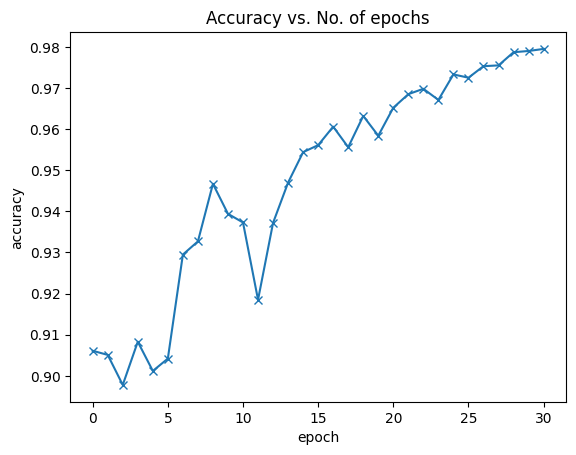

In [12]:
plot_accuracies(history_acc)

In [13]:
def plot_losses(t_loss,val_loss):
    train_losses = t_loss
    val_losses = val_loss
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

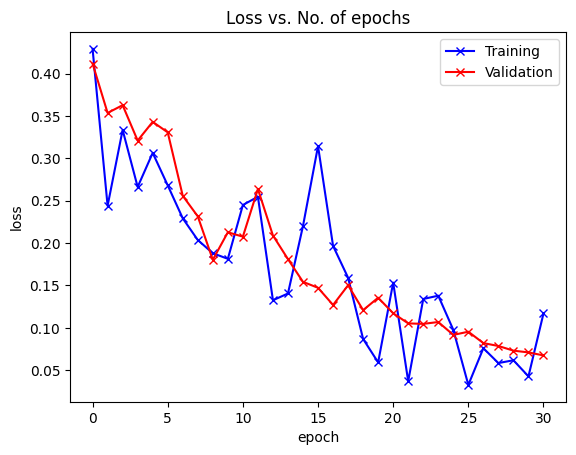

In [14]:
plot_losses(history_t_loss,history_val_loss)

# Сравнение методов


---



## Точность

часть 1 (ResNet)

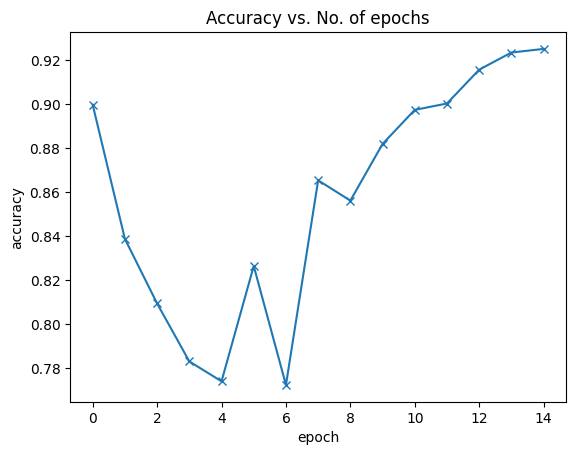

In [ ]:
plot_accuracies(history)

часть 2 (ViT)

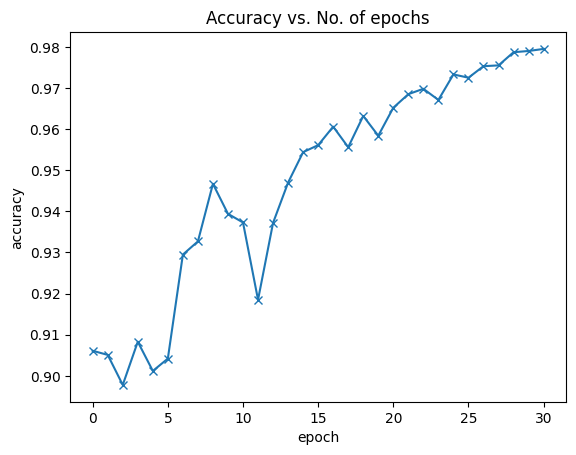

In [ ]:
plot_accuracies(history_acc)

## Функция потерь


часть 1 (ResNet)

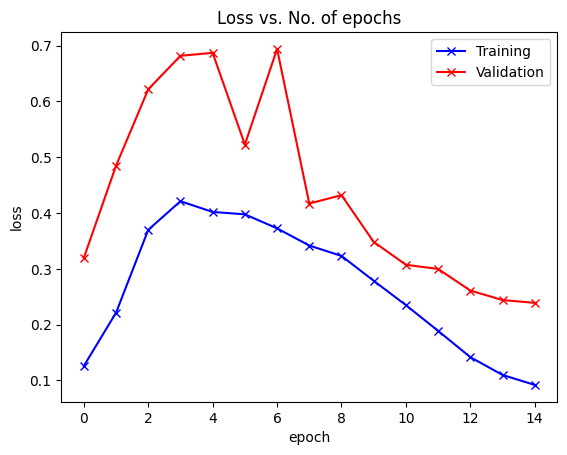

In [ ]:
plot_losses(history)

часть 2 (ViT)

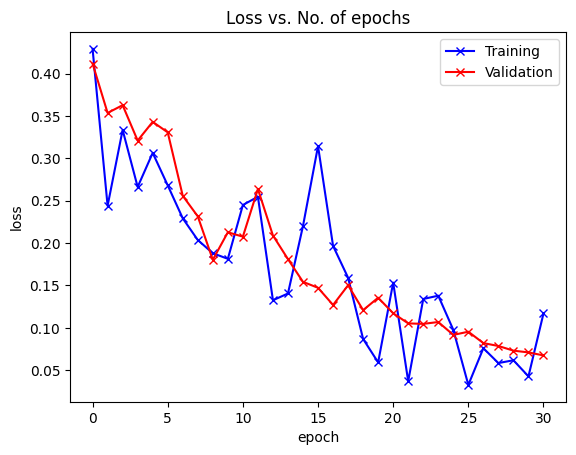

In [ ]:
plot_losses(history_t_loss,history_val_loss)

## параметры обучения

In [ ]:
import seaborn as sns
import pandas as pd

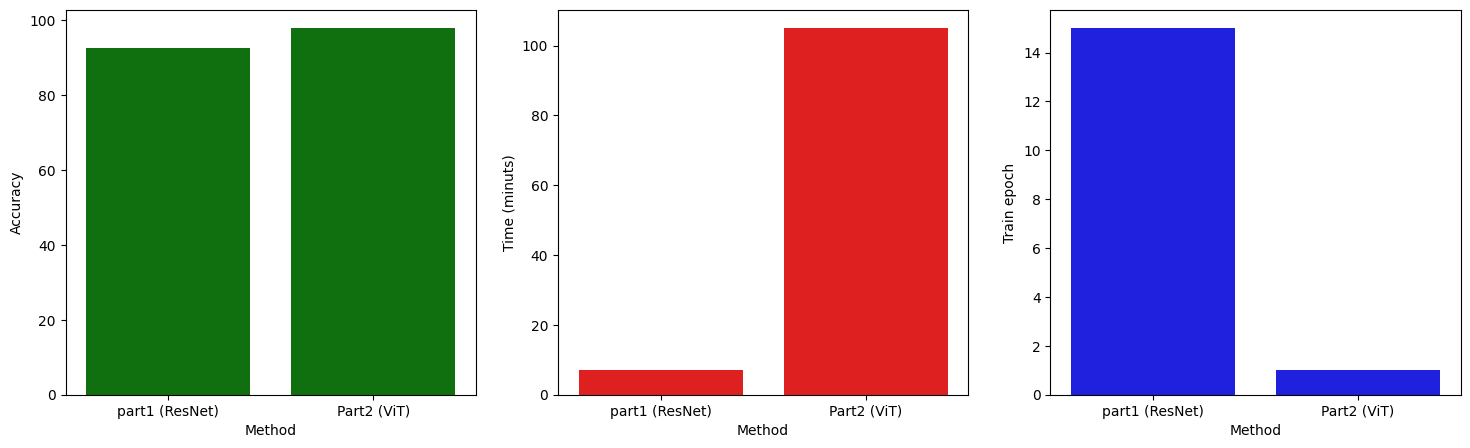

In [38]:
data = {'Method': ['part1 (ResNet)', 'Part2 (ViT)'],
        'Time (minuts)': [7, 105],
        'Accuracy': [92.52,97.95],
        'Train epoch':[15,1]}
df = pd.DataFrame(data)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(df, x='Method', y='Accuracy', ax=ax1, color='g')
sns.barplot(df, x='Method', y='Time (minuts)', ax=ax2, color='r')
sns.barplot(df, x='Method', y='Train epoch', ax=ax3, color='b')

plt.show()

## Выводы

Модели написанные и обученные с нуля работают гораздо быстрее и могут показывать отличную точность, однако благодаря более сложной структуре, дольшему обучению и в частности в использованной модели ViT допольнительной предобученой модели для фокуса внимания, предобученные модели имеют гораздо больший потенциал и могут приблизиться к точности в 100%. Этот вывод можно сделать обратив внимание на количество эпох затраченных на обучение каждой из моделей.

Таким образом если в задаче приоритетна точность лучше использовать большие предобученные модели, если же в приоритете стоит скорость работы и вес модели или есть ограничения в ресурсах для обучения модели лучше использовать небольшие самостоятельно написанные и обученые модели.

